In [1]:
from saf.preprocessing_functions import mask_and_blur_annulus
from saf.ratchet_model import calculate_offsets
from saf.filters import n_fold_filter, annulus_filter
import numpy as np
import matplotlib.pyplot as plt

The numors are:
56358, 56059, 55760, 55461, 55162, 54863, 54261

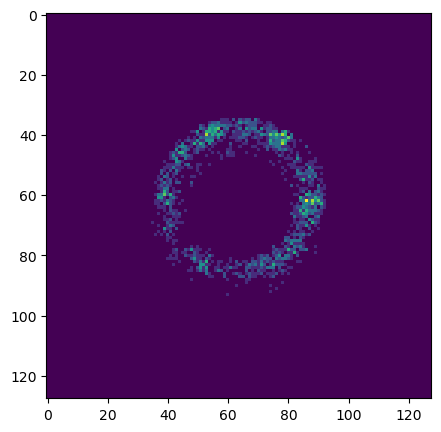

In [2]:
data_dir = '/Users/cadenmyers/billingelab/dev/sym_adapted_filts/data/SkL_data/npz_sept_numor_data/'
numor = 56358
dps = np.load(data_dir + f'{numor}.npz')['data']
dps_masked = mask_and_blur_annulus(dps, blur=False, inner_radius=17)
plt.figure(figsize=(5, 5))
plt.imshow(dps_masked[0])

0: Best r_0: 24.0, Maximum sum: 200571.1218137558
1: Best r_0: 24.0, Maximum sum: 196184.45012404612
2: Best r_0: 24.0, Maximum sum: 194468.7433623146
3: Best r_0: 24.0, Maximum sum: 190152.0025872436
4: Best r_0: 24.0, Maximum sum: 195829.098402942
5: Best r_0: 24.0, Maximum sum: 199674.5563421254
6: Best r_0: 24.0, Maximum sum: 191497.97754328954
7: Best r_0: 24.0, Maximum sum: 191302.23767028714
8: Best r_0: 24.0, Maximum sum: 192655.77819478785
9: Best r_0: 24.0, Maximum sum: 196266.01609857485
10: Best r_0: 24.0, Maximum sum: 203575.94632200056
11: Best r_0: 24.0, Maximum sum: 196099.9840584592
12: Best r_0: 24.0, Maximum sum: 176203.47381430527
13: Best r_0: 24.0, Maximum sum: 185642.33131181123
14: Best r_0: 24.0, Maximum sum: 183717.05768710695
15: Best r_0: 24.0, Maximum sum: 184964.30606528622
16: Best r_0: 24.0, Maximum sum: 191061.6451204014
17: Best r_0: 24.0, Maximum sum: 199894.9898056316
18: Best r_0: 24.0, Maximum sum: 197823.14772199
19: Best r_0: 24.0, Maximum sum: 1

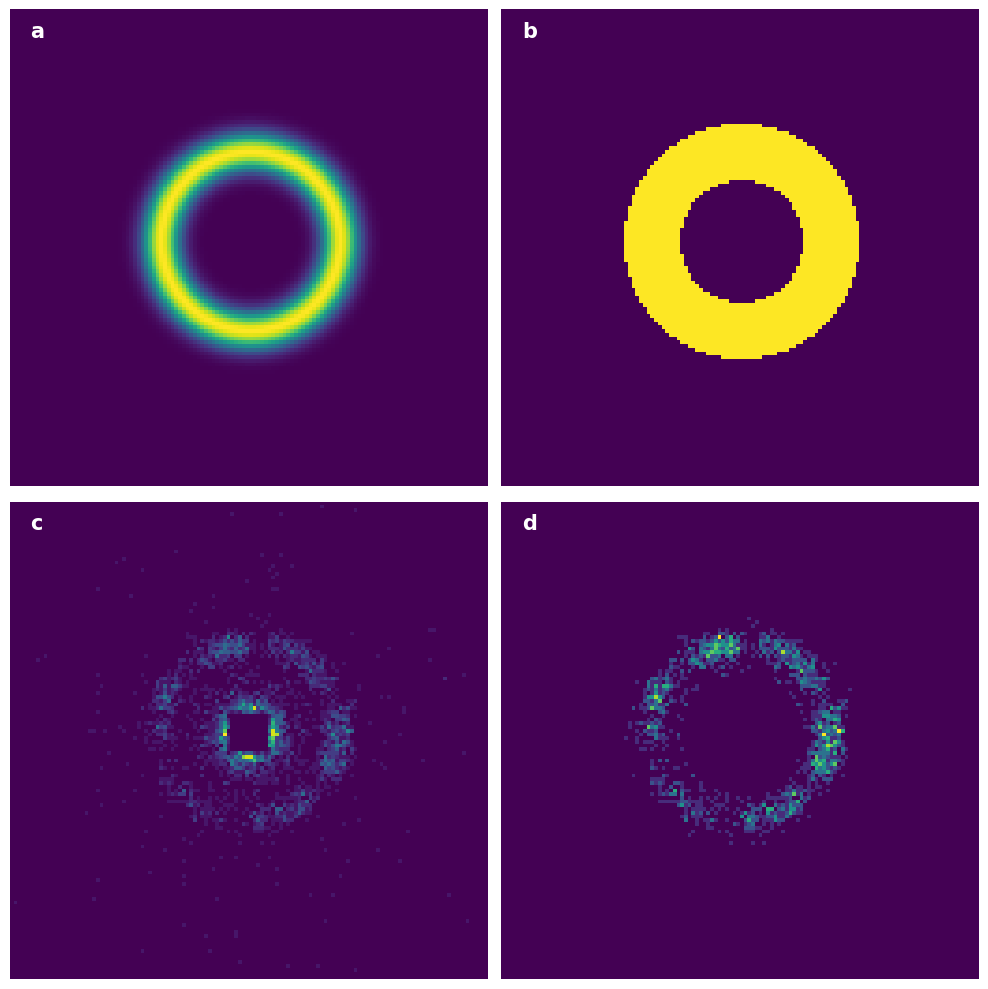

In [3]:
# determine r value for the masking
best_rs = []

for i in range(0, 299):
    best_r_0 = None
    max_sum = -np.inf
    for r_0 in np.arange(20, 40, .5):  # Iterate through a range of r_0 values
        a = annulus_filter(r_0=r_0, sd=3, cx=64, cy=62, imshape=dps[i].shape)
        current_sum = (dps[i] * a).sum()
        if current_sum > max_sum:
            max_sum = current_sum
            best_r_0 = r_0
    best_rs.append(best_r_0)
    # print(f"{i}: Best r_0: {best_r_0}, Maximum sum: {max_sum}")

average_best_r_0 = np.mean(best_rs)
print(f"Average of best_r_0 values: {average_best_r_0}")
a = annulus_filter(r_0=average_best_r_0, sd=3.5, cx=64, cy=62, imshape=dps[i].shape)
a_thresholded = np.where(a < 0.1, 0, 1)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fontsize = 15
ax[0, 0].imshow(a)
ax[0, 0].text(5, 7, 'a', color='white', fontsize=fontsize, fontweight='bold')

ax[0, 1].imshow(a_thresholded)
ax[0, 1].text(5, 7, 'b', color='white', fontsize=fontsize, fontweight='bold')

ax[1, 0].imshow(dps[i])
ax[1, 0].text(5, 7, 'c', color='white', fontsize=fontsize, fontweight='bold')

ax[1, 1].imshow(dps[i] * a_thresholded)
ax[1, 1].text(5, 7, 'd', color='white', fontsize=fontsize, fontweight='bold')

for axis in ax.flatten():
    axis.axis('off')
plt.tight_layout()
plt.savefig('/Users/cadenmyers/billingelab/dev/sym_adapted_filts/figures/mask_dps.pdf')
plt.show()


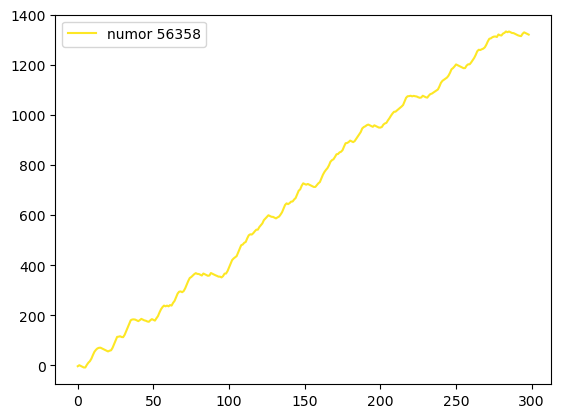

In [ ]:
# Calculate offsets for for non-blurred data
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

numors = [56358, 56059, 55760, 55461, 55162, 54863, 54261]

norm = Normalize(vmin=min(numors), vmax=max(numors))  # Normalize numors to [0, 1]

def get_orientation(numors, blur):
    offset1s = []
    offset2s = []
    for numor in numors:
        dps = np.load(data_dir + f'{numor}.npz')['data']
        dps_masked = mask_and_blur_annulus(dps, blur=blur)
        offset1, offset2, overlap1, overlap2 = calculate_offsets(
            dps_masked, n_folds=6, k=8.55, tolerance_forward=15, tolerance_reverse=3
        )
        offset1s.append(offset1)
        offset2s.append(offset2)
        color = viridis(norm(numor))
        plt.plot(offset1, label=f'numor {numor}', color=color)

    plt.legend()
    plt.show()
    return offset1s, offset2s, overlap1, overlap2

offset1raw, offset2raw, overlap1, overlap2 = get_orientation(numors, blur=False)

# offset1blur, offset2blur = get_orientation(numors, blur=True)

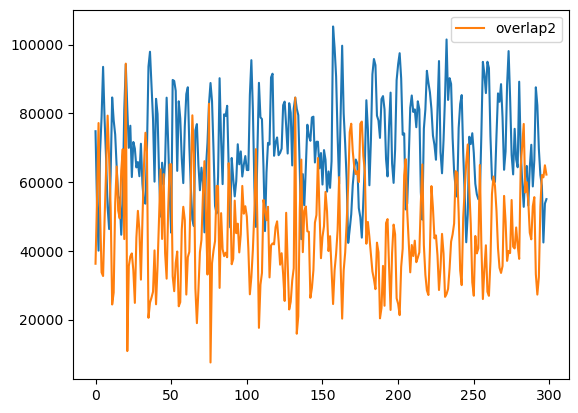

In [9]:
plt.plot(-np.array(overlap1))
plt.plot(-np.array(overlap2), label='overlap2')
plt.legend()


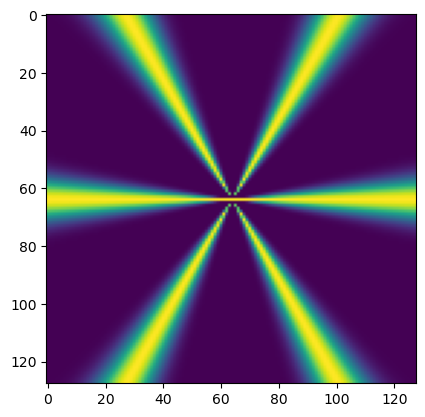

In [47]:
f = n_fold_filter(k=8.55, offset=0, n_folds=6, imshape=(128, 128))
plt.imshow(f)


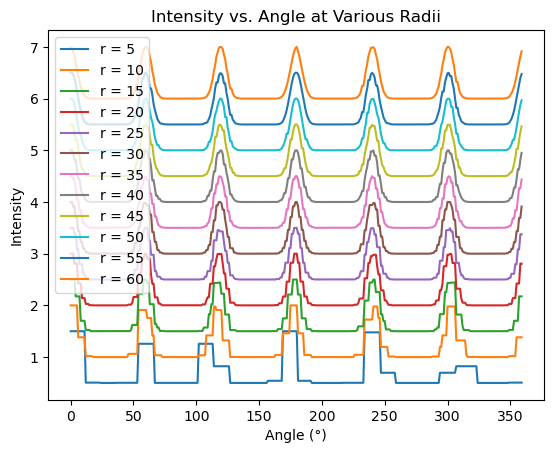

In [48]:

def intensity_vs_phi(f, r_values=np.arange(5, 65, 5), center=None, n_phi=360):
    """Plots intensity vs angle (phi) for specified radii in a 2D image."""
    if center is None:
        center = (f.shape[0] // 2, f.shape[1] // 2)
    if r_values is None:
        r_values = np.arange(5, min(f.shape) // 2, 5)

    phis = np.linspace(0, 2 * np.pi, n_phi, endpoint=False)

    for r in r_values:
        x = center[1] + r * np.cos(phis)
        y = center[0] + r * np.sin(phis)
        intensities = f[y.astype(int), x.astype(int)]
        plt.plot(np.degrees(phis), intensities+r/10, label=f"r = {r}")

    plt.xlabel("Angle (°)")
    plt.ylabel("Intensity")
    plt.title("Intensity vs. Angle at Various Radii")
    plt.legend()
    plt.show()

intensity_vs_phi(f)


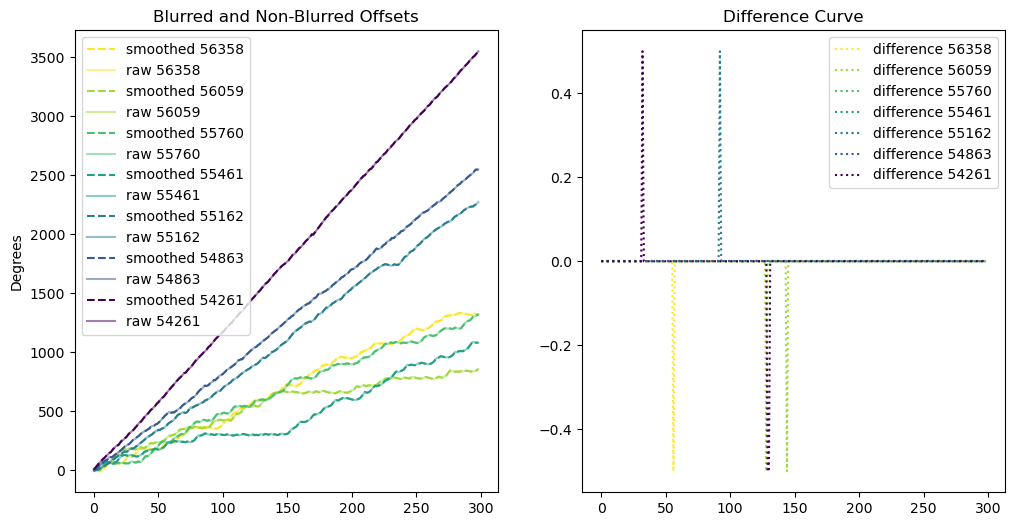

In [60]:
# plot blurred and non-blurred offsets

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot blurred and non-blurred offsets
for i, numor in enumerate(numors):
    axs[0].plot(offset1blur[i], label=f'smoothed {numor}', color=viridis(norm(numor)), linestyle='--')
    axs[0].plot(offset1raw[i], label=f'raw {numor}', alpha=.5, color=viridis(norm(numor)))
axs[0].set_title("Blurred and Non-Blurred Offsets")
axs[0].legend()
axs[0].set_ylabel("Degrees")

# Plot difference curve
for i, numor in enumerate(numors):
    axs[1].plot(np.array(offset1blur[i]) - np.array(offset1raw[i]), label=f'difference {numor}', color=viridis(norm(numor)), linestyle=':')
axs[1].set_title("Difference Curve")
axs[1].legend()

plt.show()

    # plt.plot(smoothed_offset1 - offset1s[i], label=f'difference numor {numor}', color=viridis(norm(numor)), linestyle=':')

Average of best_r_0 values: 22.747491638795985


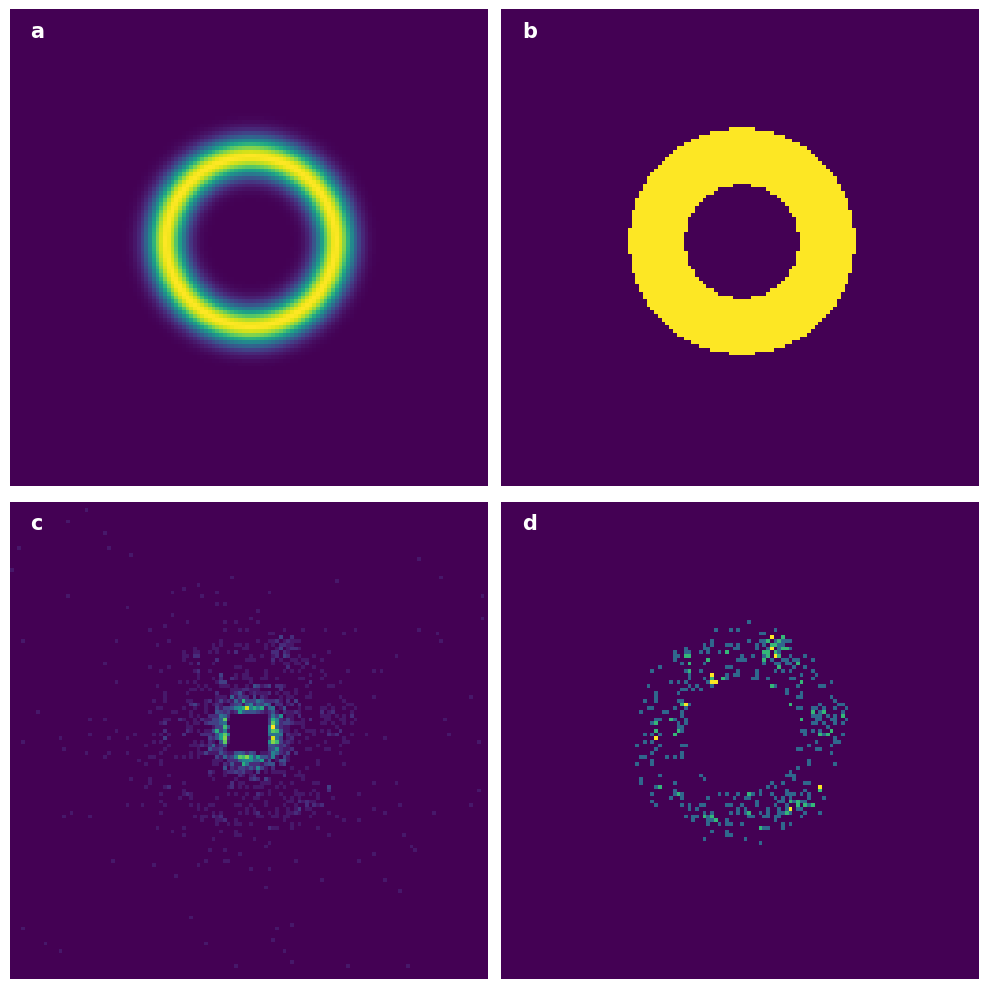

In [ ]:
# determine r value for the masking
best_rs = []

for i in range(0, 299):
    best_r_0 = None
    max_sum = -np.inf
    for r_0 in np.arange(20, 40, .5):  # Iterate through a range of r_0 values
        a = annulus_filter(r_0=r_0, sd=3, cx=64, cy=62, imshape=dps[i].shape)
        current_sum = (dps[i] * a).sum()
        if current_sum > max_sum:
            max_sum = current_sum
            best_r_0 = r_0
    best_rs.append(best_r_0)
    print(f"{i}: Best r_0: {best_r_0}, Maximum sum: {max_sum}")

average_best_r_0 = np.mean(best_rs)
print(f"Average of best_r_0 values: {average_best_r_0}")
a = annulus_filter(r_0=average_best_r_0, sd=3.5, cx=64, cy=62, imshape=dps[i].shape)
a_thresholded = np.where(a < 0.1, 0, 1)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fontsize = 15
ax[0, 0].imshow(a)
ax[0, 0].text(5, 7, 'a', color='white', fontsize=fontsize, fontweight='bold')

ax[0, 1].imshow(a_thresholded)
ax[0, 1].text(5, 7, 'b', color='white', fontsize=fontsize, fontweight='bold')

ax[1, 0].imshow(dps[i])
ax[1, 0].text(5, 7, 'c', color='white', fontsize=fontsize, fontweight='bold')

ax[1, 1].imshow(dps[i] * a_thresholded)
ax[1, 1].text(5, 7, 'd', color='white', fontsize=fontsize, fontweight='bold')

for axis in ax.flatten():
    axis.axis('off')
plt.tight_layout()
plt.savefig('/Users/cadenmyers/billingelab/dev/sym_adapted_filts/figures/mask_dps.pdf')
plt.show()
